In [1]:
import tensorflow as tf
import os
import math
import numpy as np
import matplotlib.pyplot as plt

batch_size = 32
num_epochs = 50
random_seed = 42

## **Preparing the Dataset**

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
img_height, img_width = x_train.shape[1:]
img_channels = 1
input_shape = (img_height, img_width, img_channels)

# For the following experiments, we will however not use the class labels
del y_train
del y_test

# Normalizing the img data
x_train, x_test = x_train / 255.0, x_test / 255.0

# Even though we will use again a basic fully-connected network, we need to preserve
# the image format of the sample this time, to use the Keras image pre-processing
# tool to add noise. Therefore, the augmented images will be flattened by the network
# itself via a initial Flatten() layer
x_train = x_train.reshape((-1, img_height, img_width, img_channels))
x_test = x_test.reshape((-1, img_height, img_width, img_channels))

print("Shape of training set: {}".format(x_train.shape))
print("Shape of testing set: {}".format(x_test.shape))

# Setting some variables
batch_size = 64
train_steps_per_epoch = len(x_train) // batch_size
val_steps_per_epoch = len(x_test) // batch_size

11501568/11490434 [==============================] - 0s 0us/step
Shape of training set: (60000, 28, 28, 1)
Shape of testing set: (10000, 28, 28, 1)


## **Building an Auto-Encoder for Image Denoising**

Denoising auto-encoders are normal auto-encoders, but **fed with corrupted samples** while still trying to recover the original images. Therefore, we need to instantiate our network, and build a method to corrupt our images

### **Simple auto-encoder**

In [3]:
code_size = 32

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Flatten, Reshape

inputs = Input(shape=input_shape, name='input')

# As previously mentioned, the image flattening is done here
inputs_flat = Flatten()(inputs)

# Encoding layers
enc_1 = Dense(128, activation='relu', name='enc_dense1')(inputs_flat)
enc_2 = Dense(64, activation='relu', name='enc_dense2')(enc_1)
code = Dense(code_size, activation='relu', name='enc_dense3')(enc_2)

# Decoding layers
dec_1 = Dense(64, activation='relu', name='dec_dense1')(code)
dec_2 = Dense(128, activation='relu', name='dec_dense2')(dec_1)
decoded = Dense(np.prod(input_shape), activation='sigmoid', name='dec_dense3')(dec_2)
# Note: we use a sigmoid for the last activation, as we want the output values
# to be between 0 and 1, like the input ones

# Finally, we reshape the decoded data so it has the same shape as the input samples
decoded_reshape = Reshape(input_shape)(decoded)

# Auto-encoder model:
autoencoder = Model(inputs, decoded_reshape)
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
enc_dense1 (Dense)           (None, 128)               100480    
_________________________________________________________________
enc_dense2 (Dense)           (None, 64)                8256      
_________________________________________________________________
enc_dense3 (Dense)           (None, 32)                2080      
_________________________________________________________________
dec_dense1 (Dense)           (None, 64)                2112      
_________________________________________________________________
dec_dense2 (Dense)           (None, 128)               8320  

### **Generator of noisy images**

We now set up our input pipeline, adding a pre-processing step to corrupt our images. We will use this simple function for that:

In [5]:
def add_noise(img, min_noise_factor=.3, max_noise_factor=.6):
    """
    Add some random noise to an image, from a uniform distribution
    :param img: Image to corrupt
    :param min_noise_factor: Min. value for the noise random avg. amplitude
    :param max_noise_factor: Max. value for the noise random avg. amplitude
    :return : Corrupted image
    """
    
    # Generating and applying noise to image
    noise_factor = np.random.uniform(min_noise_factor, max_noise_factor)
    noise = np.random.normal(loc=0.0, scale=noise_factor, size=img.shape)
    img_noisy = img + noise
    
    # Making sure the image value are still in the proper range
    img_noisy = np.clip(img_noisy, 0., 1.)
    
    return img_noisy

Let us have a look how this affects our images. To visualize some results, we first implement the following method to draw grids to results

In [6]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def plot_image_grid(images, titles=None, figure=None,
                   grayscale=False, transpose=False):
    """
    Plot a grid of n x m images
    :param images: Images in a n x m array
    :param titles: (opt.) List of m titles for each iamge column
    :param figure: (opt.) Pyplot figure (if None, will be created)
    :param grayscale: (opt.) Flag to draw the images in grayscale
    :param transpose: (opt.) Flag to transpose the grid
    :return : Pyplot figure filled with the images
    """
    
    num_cols, num_rows = len(images), len(images[0])
    img_ratio = images[0][0].shape[1] / images[0][0].shape[0]
    
    if transpose:
        vert_grid_shape, hori_grid_shape = (1, num_rows), (num_cols, 1)
        figsize = (int(num_rows * 5 * img_ratio), num_cols * 5)
        wspace, hspace = 0.2, 0.
    else:
        vert_grid_shape, hori_grid_shape = (num_rows, 1), (1, num_cols)
        figsize = (int(num_cols * 5 * img_ratio), num_rows * 5)
        hspace, wspace = 0.2, 0.
        
    if figure is None:
        figure = plt.figure(figsize=figsize)
    imshow_params = {'cmap': plt.get_cmap('gray')} if grayscale else {}
    grid_spec = gridspec.GridSpec(*hori_grid_shape, wspace=0, hspace=0)
    
    for j in range(num_cols):
        grid_spec_j = gridspec.GridSpecFromSubplotSpec(
            *vert_grid_shape, subplot_spec=grid_spec[j], 
            wspace=wspace, hspace=hspace)
        
        for i in range(num_rows):
            ax_img = figure.add_subplot(grid_spec_j[i])
            #ax_img.axis('off')
            ax_img.set_yticks([])
            ax_img.set_xticks([])
            if titles is not None:
                if transpose:
                    ax_img.set_ylabel(titles[j], fontsize=25)
                else:
                    ax_img.set_title(titles[j], fontsize=15)
                    
            ax_img.imshow(images[j][i], **imshow_params)
            
    figure.tight_layout()
    
    return figure

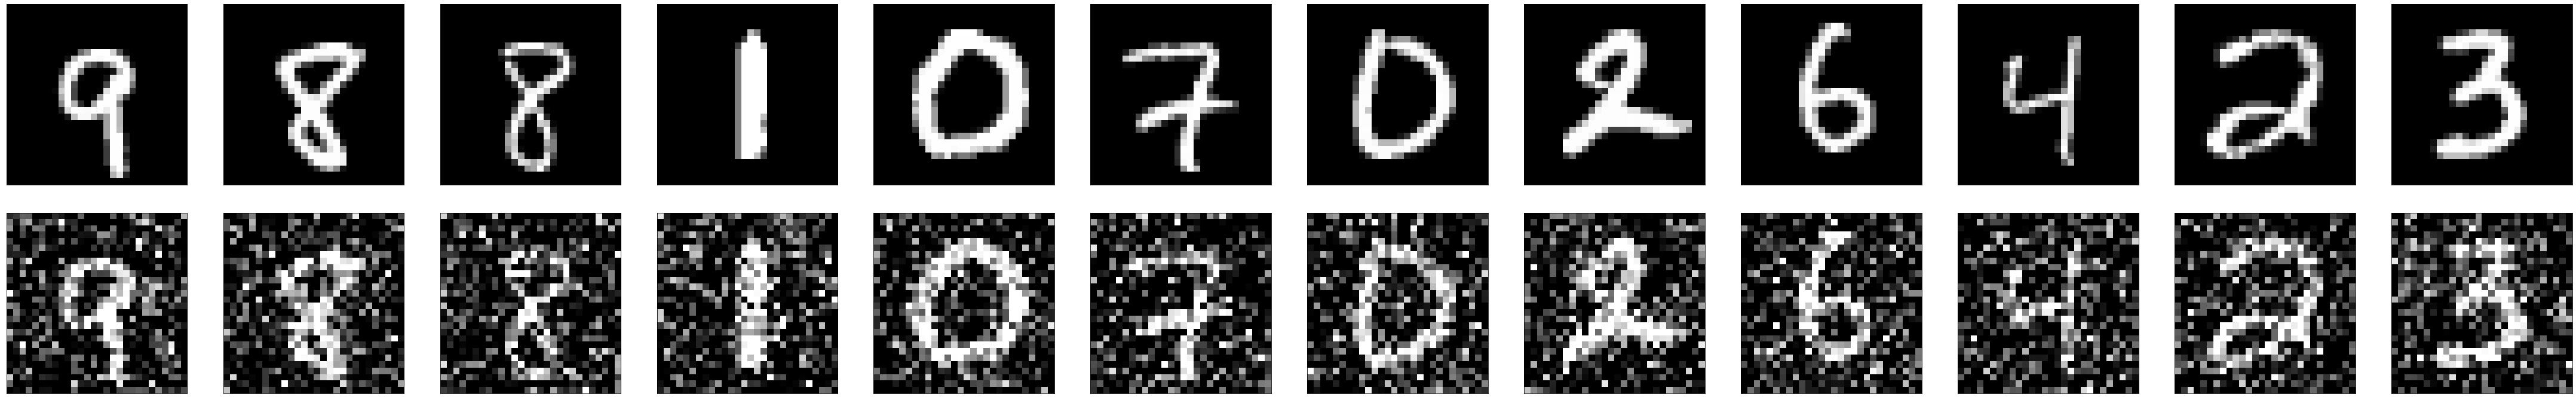

In [7]:
num_show = 12
random_image_indices = np.random.choice(len(x_test), size=num_show)

orig_samples = x_test[random_image_indices]
noisy_samples = add_noise(orig_samples)

fig = plot_image_grid([np.squeeze(orig_samples), np.squeeze(noisy_samples)], 
                     grayscale=True, transpose=True)

Our corrupting function is doing its job, adding some *salt-and-pepper* noise. Some digits are even hard to recognize. Let us see how our denoising model will manage

We now have a choice. We could simply apply our noise function to the whole training set `x_noisy = add_noise(x_train)` and pass it to our model for training `autoencoder.fit(x_noisy, x_train)`. While straightforward, this solution has one inconvenient: each original image has only one noisy version. Epoxh after epoch, the network will receive the same noisy images. There is thus a risk that it may overfit some of the data

Another solution would be to corrupt each batch of images at each iteration, thus creating different corrupted versions each time. While a bit heavier, this solution provides our network with new samples each time, making it more robust. We will therefore opt for this solution

To implement it, we will use a ***generator***, a Python object yielding new elements each time it is called. Keras models can be trained directly on datasets `model.fit(...)`, or on generators `model.fit_generator(...)`. Though less advanced that Tensorflow `tf.data.Dataset`, generators share some common advantages (e.g., for datasets too big to be loaded at once, a generator can be used to load only the images for the next batches)

Keras offers several pre-implemented generators, to iterate over image folders, image arrays, etc. Here, we will use `ImageDataGenerator`, which can iterate over numpy arrays to generate batches. This generator can also be configured to pre-process each batch before yielding it. This is exactly what we need:

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# We define our Keras generator, passing our noisy function as pre-processing step:
train_datagen = ImageDataGenerator(preprocessing_function=add_noise)

# The we pass our dataset to the generator and specify how the yielded batch 
# should be (batchsize, shuffling or not, etc.)
train_generator = train_datagen.flow(x_train, x_train, batch_size=batch_size,
                                    shuffle=True)

train_generator

Our input pipeline is ready, though we need to prepare the validation data too

To be able to consistently compare metrics from one epoch to another, we augment the validation images with noise only once, and saved the resulting images so thay can be reused for each epoch

In [9]:
x_test_noisy = add_noise(x_test)

val_datagen = ImageDataGenerator()
val_generator = train_datagen.flow(x_test_noisy, x_test, batch_size=batch_size,
                                  shuffle=False)

## **Training and Monitoring**


### **PSNR as custom metric**

We reuse PSNR,to evaluate how well our model recovered the corrupted sampled, compared to the original ones

In [10]:
import functools

psnr_metric = functools.partial(tf.image.psnr, max_val=1.)
psnr_metric.__name__ = 'psnr'

In [11]:
from tensorflow.keras.callbacks import Callback
import collections

class SimpleLogCallback(Callback):
    """ Keras callback for simple, denser console logs """
    
    def __init__(self, metrics_dict, num_epochs, log_frequency=1,
               metric_string_template='\033[1m[[name]]\033[0m = \033[94m{[[value]]:5.3f}\033[0m'):
        """
        Initialize the Callback
        :param metrics_dict: Dictionary containing mappings for metrics names/keys
                                e.g. {"accuracy": "acc", "val.accuracy": "val_acc"}
        :param num_epochs: Number of training epochs
        :param log_frequency: Log frequency (in epochs)
        :param metric_string_template: (opt.) String template to print each metric
        """
        
        super().__init__()
        
        self.metrics_dict = collections.OrderedDict(metrics_dict)
        self.num_epochs = num_epochs
        self.log_frequency = log_frequency
        
        # We build a format string to later print the metrics, (e.g.: "Epoch 0/9: loss = 1.00; val-loss = 2.00")
        log_string_template = 'Epoch {0:2}/{1}: '
        separator = ';'
        
        i = 2
        for metric_name in self.metrics_dict:
            temp1 = metric_string_template.replace('[[name]]', metric_name).replace('[[value]]', str(i))
            log_string_template += temp1 + separator
            i += 1
            
        # We remove the "; " after the last element
        log_string_template = log_string_template[:-len(separator)]
        self.log_string_template = log_string_template
        
    def on_train_begin(self, logs=None):
        print("Training: \033[92mstart\033[0m.")
        
    def on_train_end(self, logs=None):
        print("Training: \033[91mend\033[0m.")
        
    def on_epoch_end(self, epoch, logs={}):
        if (epoch - 1) % self.log_frequency == 0 or epoch == self.num_epochs:
            values = [logs[self.metrics_dict[metric_name]] for metric_name in self.metrics_dict]
            print(self.log_string_template.format(epoch, self.num_epochs, *values))

### **Training and results**

In [12]:
model_dir = os.path.join('.', 'models', 'ae_denoising_mnist')

metrics_to_print = collections.OrderedDict([("loss", "loss"),
                                            ("v-loss", "val_loss"),
                                            ("psnr", "psnr"),
                                            ("v-psnr", "val_psnr")])

callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss',
                                              restore_best_weights=True),
             SimpleLogCallback(metrics_to_print, num_epochs=num_epochs,
                               log_frequency=1)]

In [13]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=[psnr_metric])

history = autoencoder.fit(train_generator, steps_per_epoch=train_steps_per_epoch,
                         epochs=num_epochs, validation_data=val_generator, validation_steps=val_steps_per_epoch,
                         verbose=0, callbacks=callbacks)

Training: start.
Epoch  0/50: loss = 0.201;v-loss = 0.181;psnr = 13.912;v-psnr = 14.385
Epoch  1/50: loss = 0.149;v-loss = 0.159;psnr = 15.938;v-psnr = 15.300
Epoch  2/50: loss = 0.136;v-loss = 0.152;psnr = 16.644;v-psnr = 15.661
Epoch  3/50: loss = 0.129;v-loss = 0.149;psnr = 17.073;v-psnr = 15.869
Epoch  4/50: loss = 0.126;v-loss = 0.145;psnr = 17.340;v-psnr = 16.072
Epoch  5/50: loss = 0.123;v-loss = 0.144;psnr = 17.533;v-psnr = 16.105
Epoch  6/50: loss = 0.121;v-loss = 0.143;psnr = 17.693;v-psnr = 16.224
Epoch  7/50: loss = 0.119;v-loss = 0.141;psnr = 17.800;v-psnr = 16.276
Epoch  8/50: loss = 0.118;v-loss = 0.141;psnr = 17.904;v-psnr = 16.275
Epoch  9/50: loss = 0.117;v-loss = 0.140;psnr = 17.978;v-psnr = 16.340
Epoch 10/50: loss = 0.116;v-loss = 0.138;psnr = 18.038;v-psnr = 16.474
Epoch 11/50: loss = 0.116;v-loss = 0.139;psnr = 18.087;v-psnr = 16.431
Epoch 12/50: loss = 0.115;v-loss = 0.138;psnr = 18.141;v-psnr = 16.478
Epoch 13/50: loss = 0.114;v-loss = 0.138;psnr = 18.180;v-psn

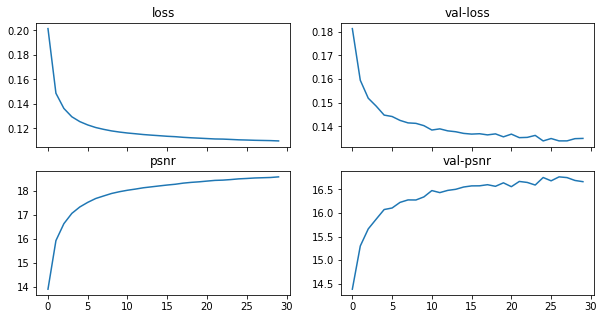

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5), sharex='col')

axs[0, 0].set_title('loss')
axs[0, 1].set_title('val-loss')
axs[1, 0].set_title('psnr')
axs[1, 1].set_title('val-psnr')

axs[0, 0].plot(history.history['loss'])
axs[0, 1].plot(history.history['val_loss'])
axs[1, 0].plot(history.history['psnr'])
axs[1, 1].plot(history.history['val_psnr'])

Though we already have results drawn in Tensorboard, let us add one last image grid to this notebook:

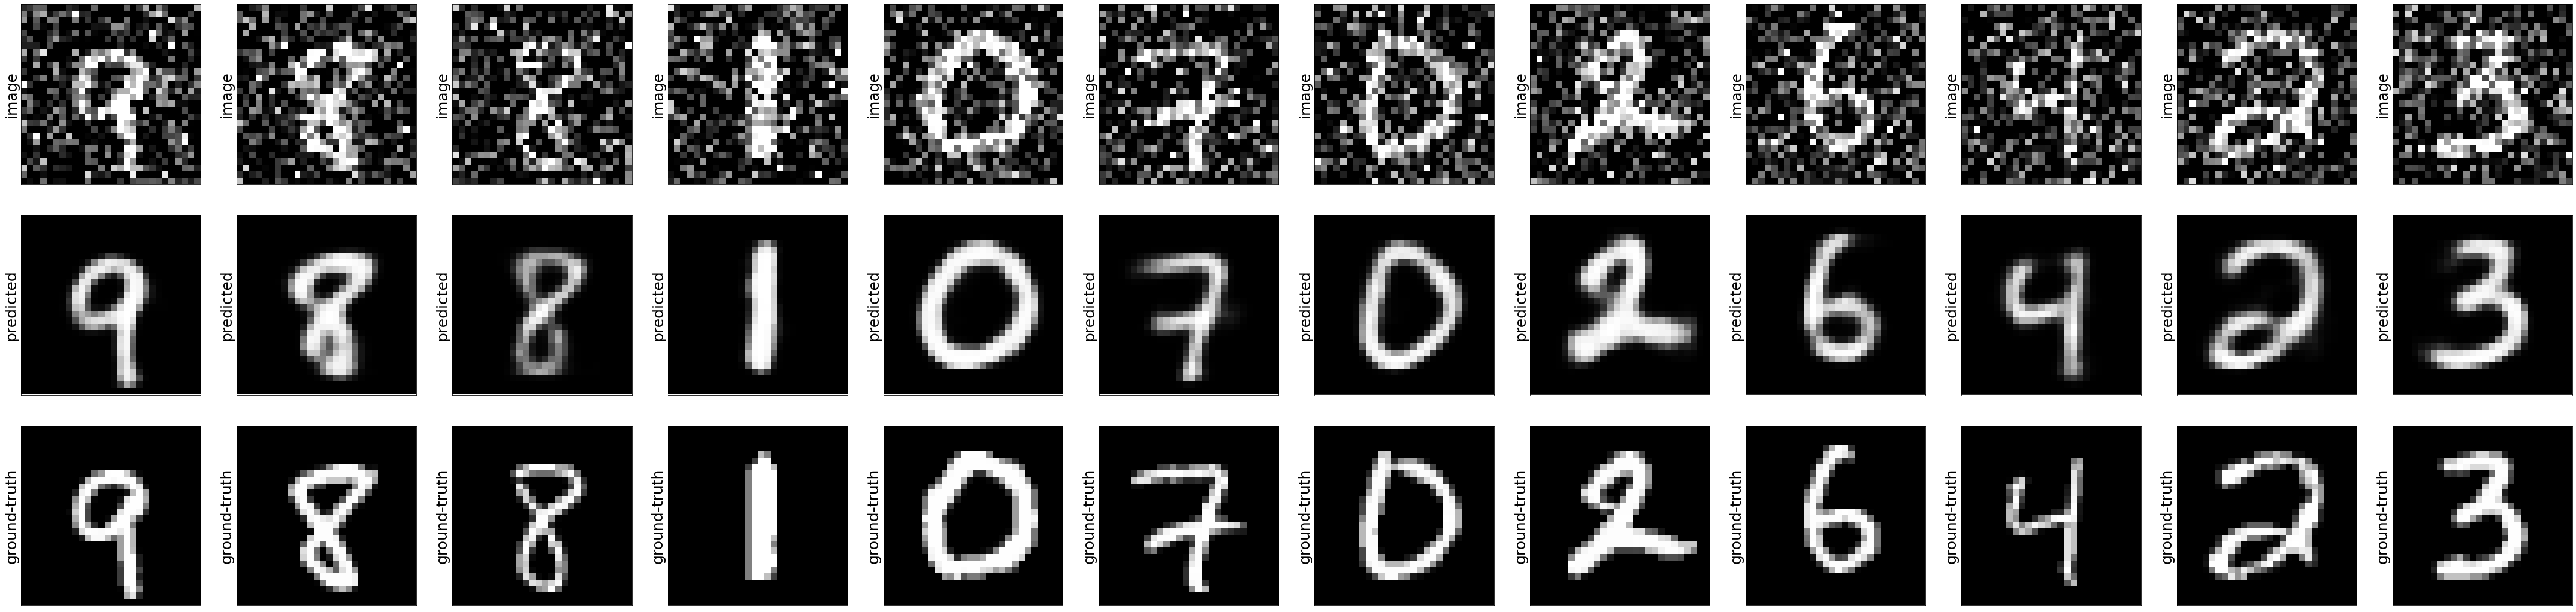

In [15]:
predicted_samples = autoencoder.predict_on_batch(noisy_samples)

fig = plot_image_grid([np.squeeze(noisy_samples),
                       np.squeeze(predicted_samples),
                       np.squeeze(orig_samples)],
                     titles=['image', 'predicted', 'ground-truth'],
                     grayscale=True, transpose=True)
fig.show()